In [26]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import seaborn as sns

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import create_tmdb_dataset
from src.utils.load_data import load_raw_data
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.models.empath_model import *
import json

# TMDB

In [27]:
df = create_tmdb_dataset('data/processed/TMDB_clean.csv')
df.head()

title release_date     revenue  runtime     budget  \
0        inception   2010-07-15   825532764      148  160000000   
1     interstellar   2014-11-05   701729206      169  165000000   
2  the dark knight   2008-07-16  1004558444      152  185000000   
3           avatar   2009-12-15  2923706026      162  237000000   
4     the avengers   2012-04-25  1518815515      143  220000000   

  original_language                                           overview  \
0                en  cobb, a skilled thief who commits corporate es...   
1                en  the adventures of a group of explorers who mak...   
2                en  batman raises the stakes in his war on crime. ...   
3                en  in the 22nd century, a paraplegic marine is di...   
4                en  when an unexpected enemy emerges and threatens...   

                                          genres  \
0           [action, science fiction, adventure]   
1            [adventure, drama, science fiction]   
2               [drama, action, crime, thriller]   
3  [action, adventure, fantasy, science fiction]   
4           [science fiction, action, adventure]   

                                production_companies  \
0  [legendary pictures, syncopy, warner bros. pic...   
1  [legendary pictures, syncopy, lynda obst produ...   
2  [dc comics, legendary pictures, syncopy, isobe...   
3  [dune entertainment, lightstorm entertainment,...   
4                                   [marvel studios]   

                         production_countries  \
0  [united kingdom, united states of america]   
1  [united kingdom, united states of america]   
2  [united kingdom, united states of america]   
3  [united states of america, united kingdom]   
4                  [united states of america]   

                       spoken_languages  \
0  [english, french, japanese, swahili]   
1                             [english]   
2                   [english, mandarin]   
3                    [english, spanish]   
4             [english, hindi, russian]   

                                            keywords  release_year dvd_era  
0  [rescue, mission, dream, airplane, paris, fran...          2010  during  
1  [rescue, future, spacecraft, race against time...          2014    post  
2  [joker, sadism, chaos, secret identity, crime ...          2008  during  
3  [future, society, culture clash, space travel,...          2009  during  
4  [new york city, superhero, shield, based on co...          2012  during

In [28]:
mean_budgets = df[df.budget > 0].groupby('release_year').agg(mean_budget = ('budget', 'mean'))
df['prod_type'] = df.apply(categorize_production, axis=1, args=(mean_budgets,))

In [29]:
df['dvd_era'] = pd.Categorical(df['dvd_era'], categories=['pre', 'during', 'post'], ordered=True)
df['prod_type'] = pd.Categorical(df['prod_type'], categories=['Independent', 'Small', 'Big', 'Super'], ordered=True)

## Production types

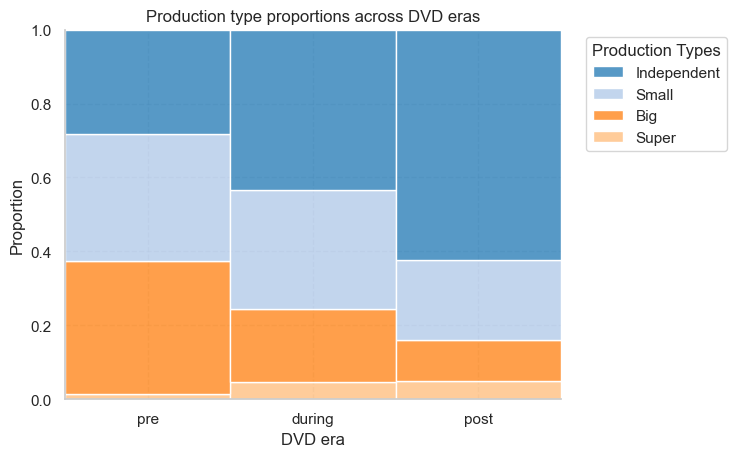

In [30]:
fig = sns.histplot(data = df[df.budget > 0], x='dvd_era', hue='prod_type', 
             multiple='fill', palette='tab20', )
sns.move_legend(fig, loc='upper right', bbox_to_anchor=(1.35,1),title='Production Types')
style_plot('Production type proportions across DVD eras', 'DVD era', 'Proportion')

## Genres and Topics analysis

In [31]:
df_genres = df[df.genres.apply(lambda x: len(x) > 0)].copy()
df_genres = df_genres.explode('genres')
df_genres.head()

title release_date    revenue  runtime     budget original_language  \
0     inception   2010-07-15  825532764      148  160000000                en   
0     inception   2010-07-15  825532764      148  160000000                en   
0     inception   2010-07-15  825532764      148  160000000                en   
1  interstellar   2014-11-05  701729206      169  165000000                en   
1  interstellar   2014-11-05  701729206      169  165000000                en   

                                            overview           genres  \
0  cobb, a skilled thief who commits corporate es...           action   
0  cobb, a skilled thief who commits corporate es...  science fiction   
0  cobb, a skilled thief who commits corporate es...        adventure   
1  the adventures of a group of explorers who mak...        adventure   
1  the adventures of a group of explorers who mak...            drama   

                                production_companies  \
0  [legendary pictures, syncopy, warner bros. pic...   
0  [legendary pictures, syncopy, warner bros. pic...   
0  [legendary pictures, syncopy, warner bros. pic...   
1  [legendary pictures, syncopy, lynda obst produ...   
1  [legendary pictures, syncopy, lynda obst produ...   

                         production_countries  \
0  [united kingdom, united states of america]   
0  [united kingdom, united states of america]   
0  [united kingdom, united states of america]   
1  [united kingdom, united states of america]   
1  [united kingdom, united states of america]   

                       spoken_languages  \
0  [english, french, japanese, swahili]   
0  [english, french, japanese, swahili]   
0  [english, french, japanese, swahili]   
1                             [english]   
1                             [english]   

                                            keywords  release_year dvd_era  \
0  [rescue, mission, dream, airplane, paris, fran...          2010  during   
0  [rescue, mission, dream, airplane, paris, fran...          2010  during   
0  [rescue, mission, dream, airplane, paris, fran...          2010  during   
1  [rescue, future, spacecraft, race against time...          2014    post   
1  [rescue, future, spacecraft, race against time...          2014    post   

  prod_type  
0     Super  
0     Super  
0     Super  
1     Super  
1     Super

In [32]:
df_genres = df_genres[df_genres.budget > 0]

In [33]:
genre_proportions = get_proportions(df_genres, base_vars=['prod_type', 'dvd_era'], target_var='genres')

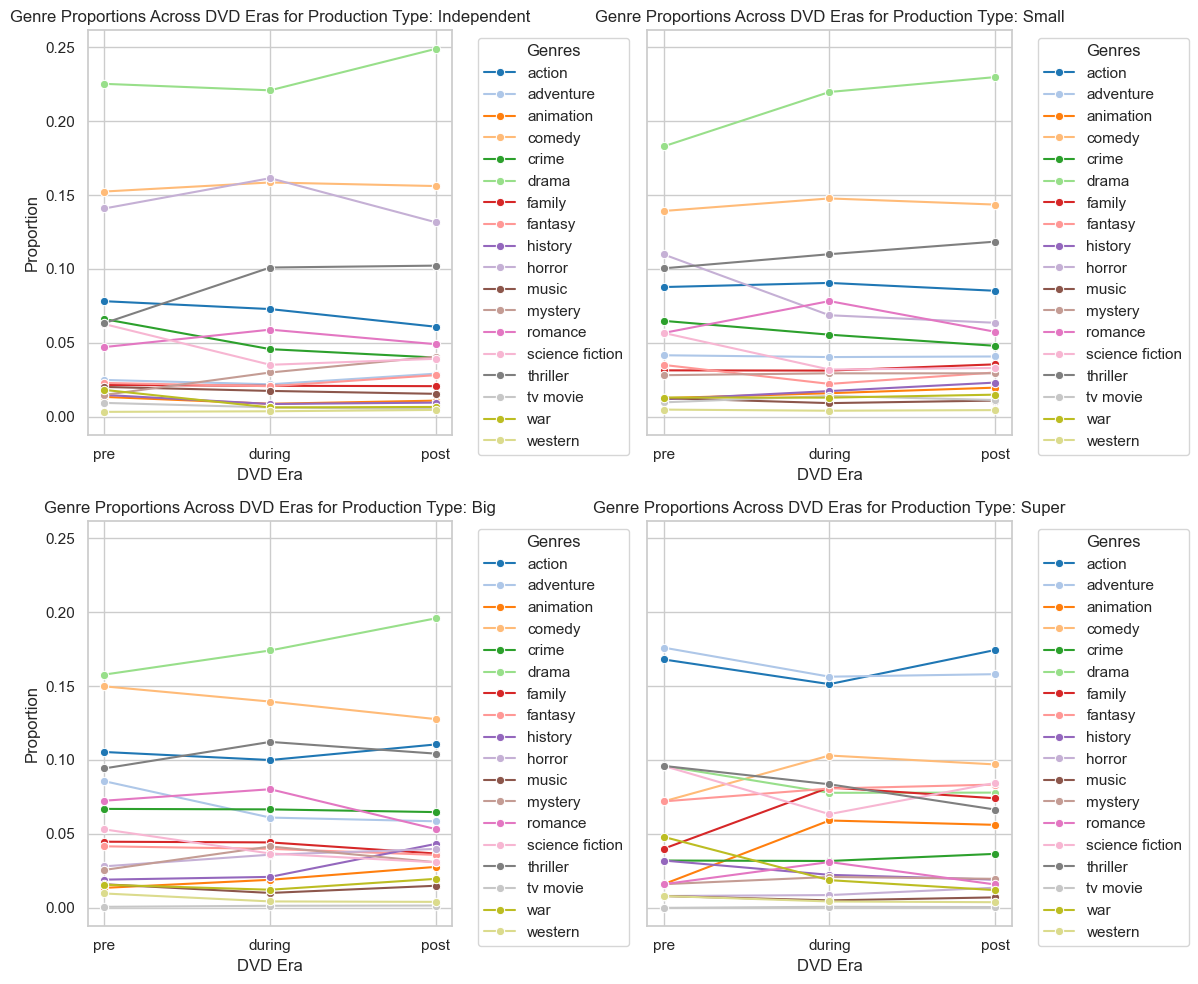

In [34]:
sns.set(style="whitegrid")
f, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
# Loop through each production type
for i, prod_type in enumerate(genre_proportions['prod_type'].unique()):
    subset = genre_proportions[genre_proportions['prod_type'] == prod_type]

    ax = axs.flatten()[i]
    sns.lineplot(data=subset, x='dvd_era', y='prop', hue='genres', marker='o', ax=ax, palette='tab20')
    ax.set_title(f"Genre Proportions Across DVD Eras for Production Type: {prod_type}")
    ax.set_xlabel('DVD Era')
    ax.set_ylabel('Proportion')
    
    ax.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

plt.show()

In [35]:
grouped_genres = genre_proportions.groupby(['prod_type', 'genres'], observed=False).sum('count').reset_index()
grouped_genres['proportion'] = grouped_genres['count'] / grouped_genres['total']

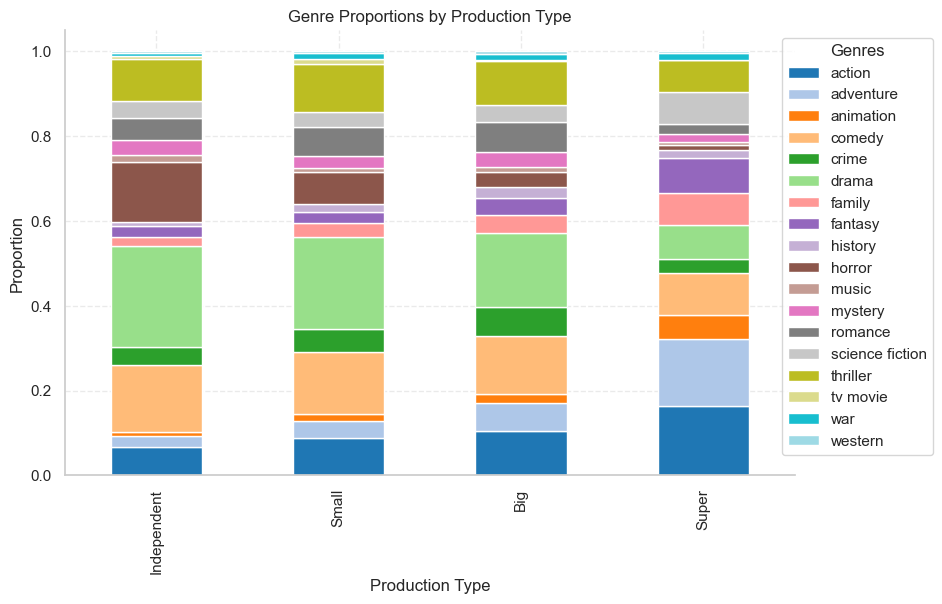

In [42]:
# Pivot the DataFrame
pivot_df = grouped_genres.pivot_table(index='prod_type', columns='genres', values='proportion', fill_value=0, observed=False)

pivot_df.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='tab20')
plt.tight_layout()
plt.legend(title="Genres", bbox_to_anchor=(1.2, 1), loc='upper right')
style_plot("Genre Proportions by Production Type", "Production Type", "Proportion")

### Topics extraction

In [36]:
df_genres['clean_overview'] = df_genres.overview.apply(clean_text)

In [37]:
empathModel = EmpathModel()
selected_genres = ['drama', 'comedy', 'action', 'adventure']
prod_types = ['Independent', 'Small', 'Big', 'Super']
results = empathModel.get_features_genres_prods(df_genres, selected_genres, prod_types)
results.head()
# for website: 
# results = pd.read_csv('./data/website_data/topics_per_genre_prod.csv')

Extracting features for Independent drama movies
Extracting features for Small drama movies
Extracting features for Big drama movies
Extracting features for Super drama movies
Extracting features for Independent comedy movies
Extracting features for Small comedy movies
Extracting features for Big comedy movies
Extracting features for Super comedy movies
Extracting features for Independent action movies
Extracting features for Small action movies
Extracting features for Big action movies
Extracting features for Super action movies
Extracting features for Independent adventure movies
Extracting features for Small adventure movies
Extracting features for Big adventure movies
Extracting features for Super adventure movies


prod_type  genre     word     era    factor
0  Independent  drama  friends  during  0.026206
1  Independent  drama    youth  during  0.015313
2  Independent  drama   family  during  0.031100
3  Independent  drama    party  during  0.016711
4  Independent  drama     home  during  0.020703

In [38]:
results.to_csv('./data/website_data/TMDB/topics_per_genre_prod.csv', index=False)

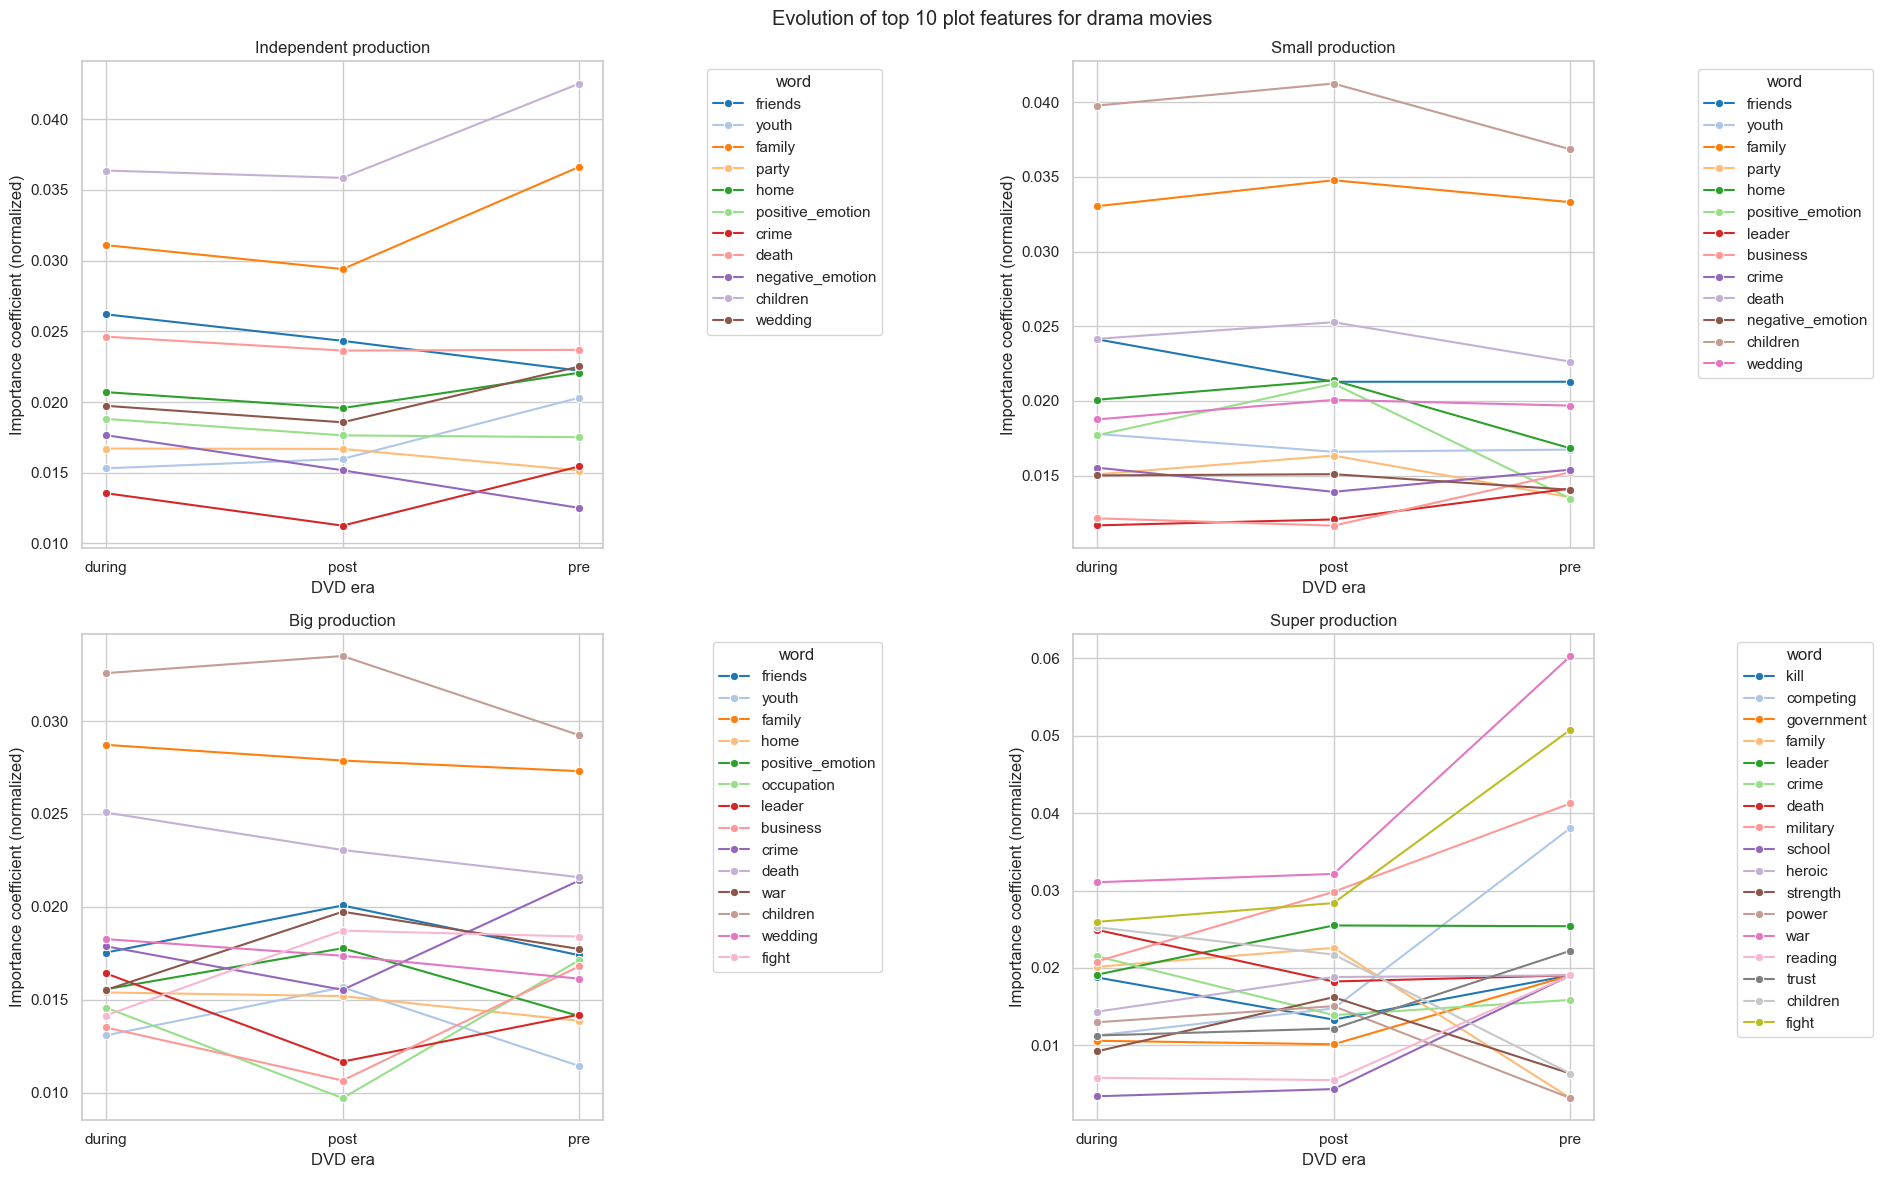

In [39]:
empathModel.plot_all_features(results, 'drama')

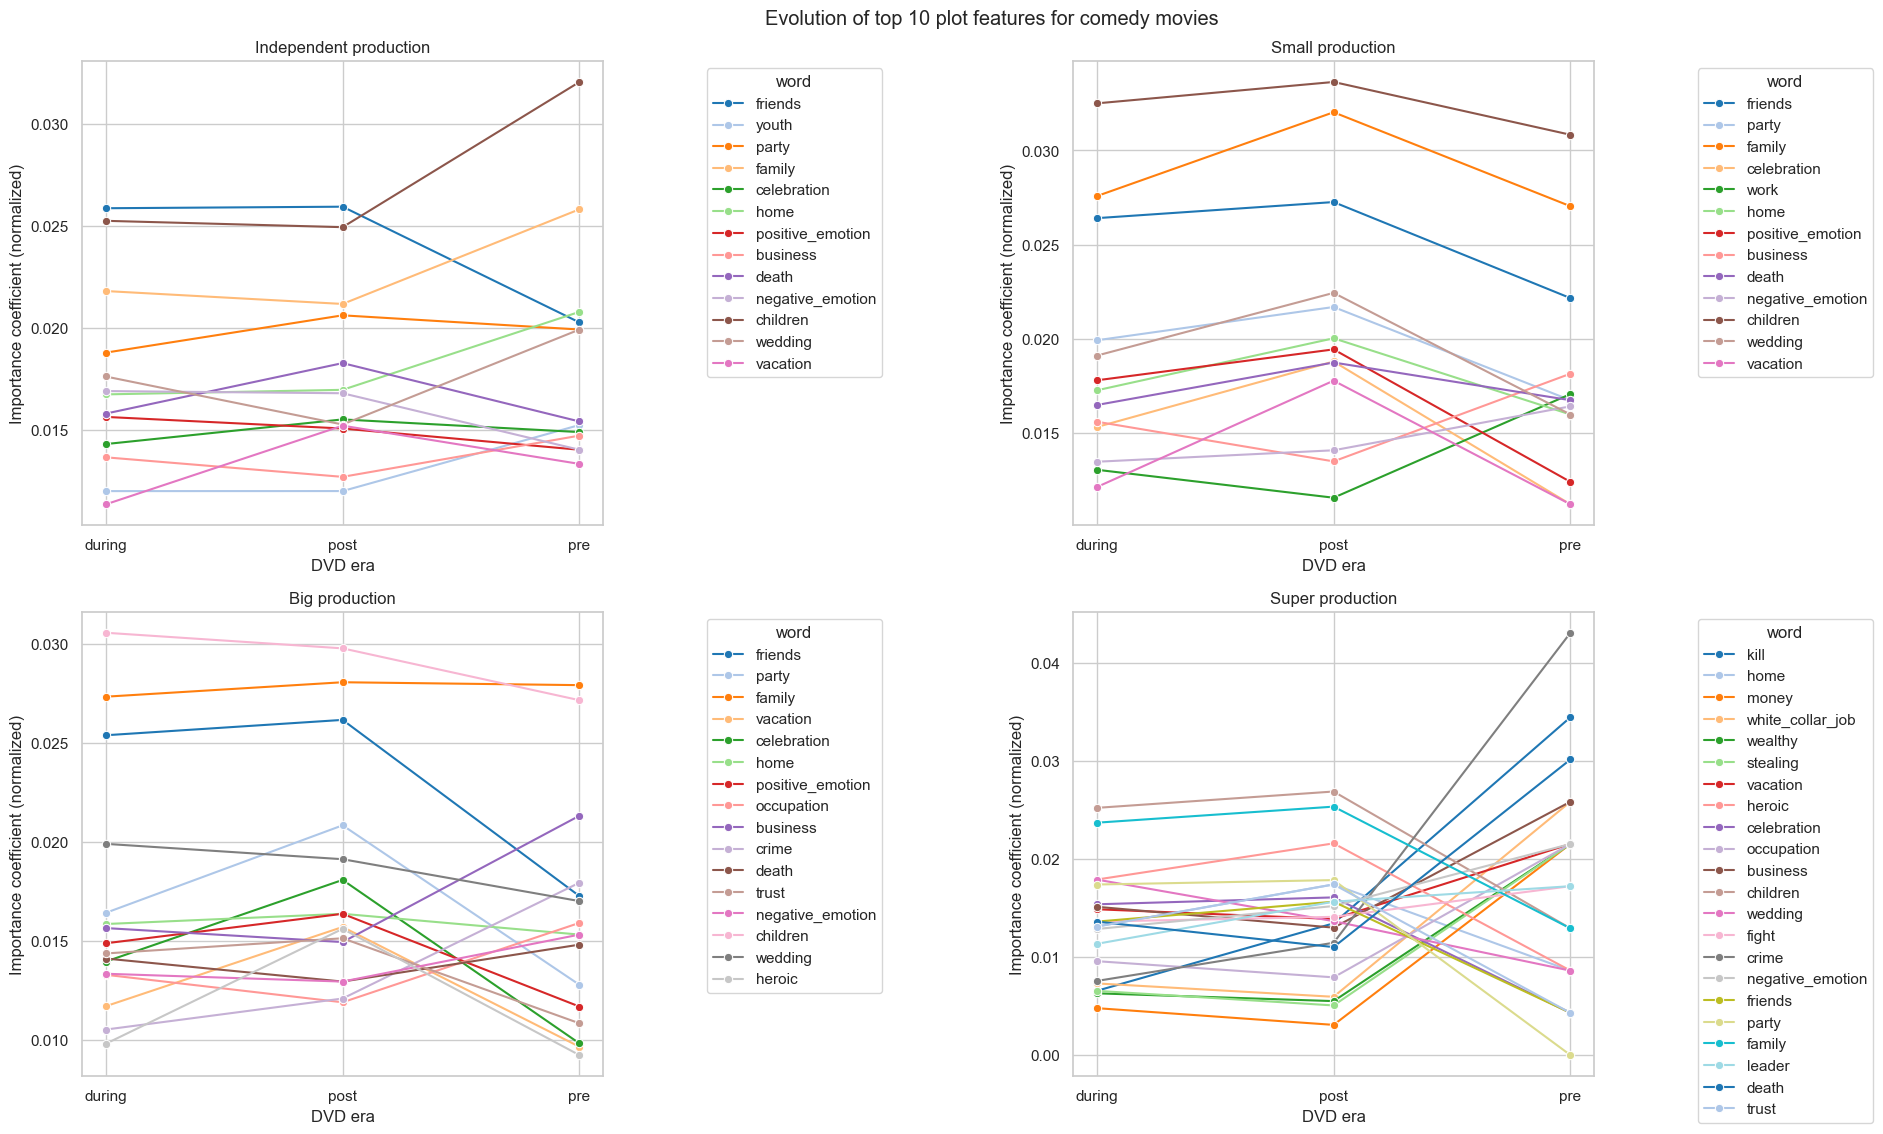

In [40]:
empathModel.plot_all_features(results, 'comedy')

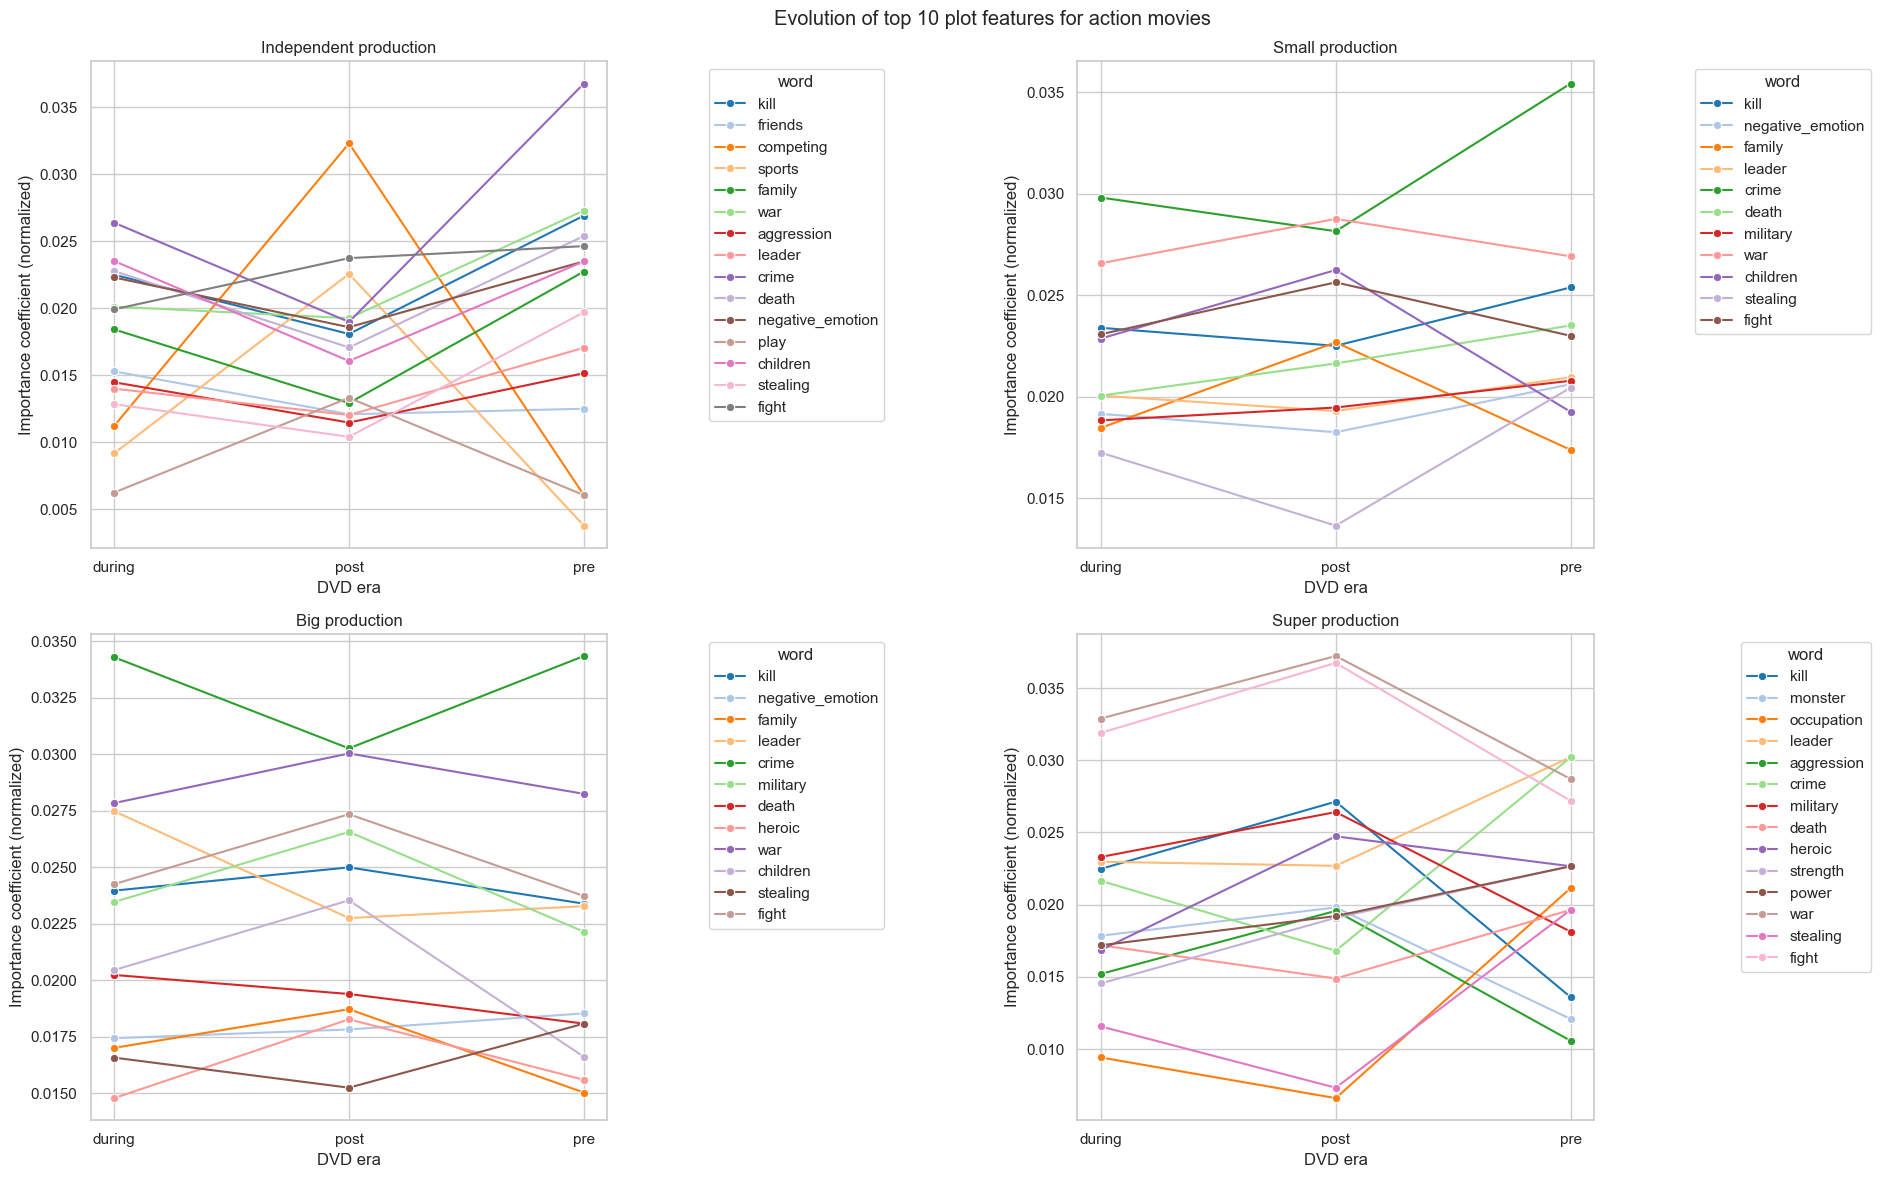

In [41]:
empathModel.plot_all_features(results, 'action')

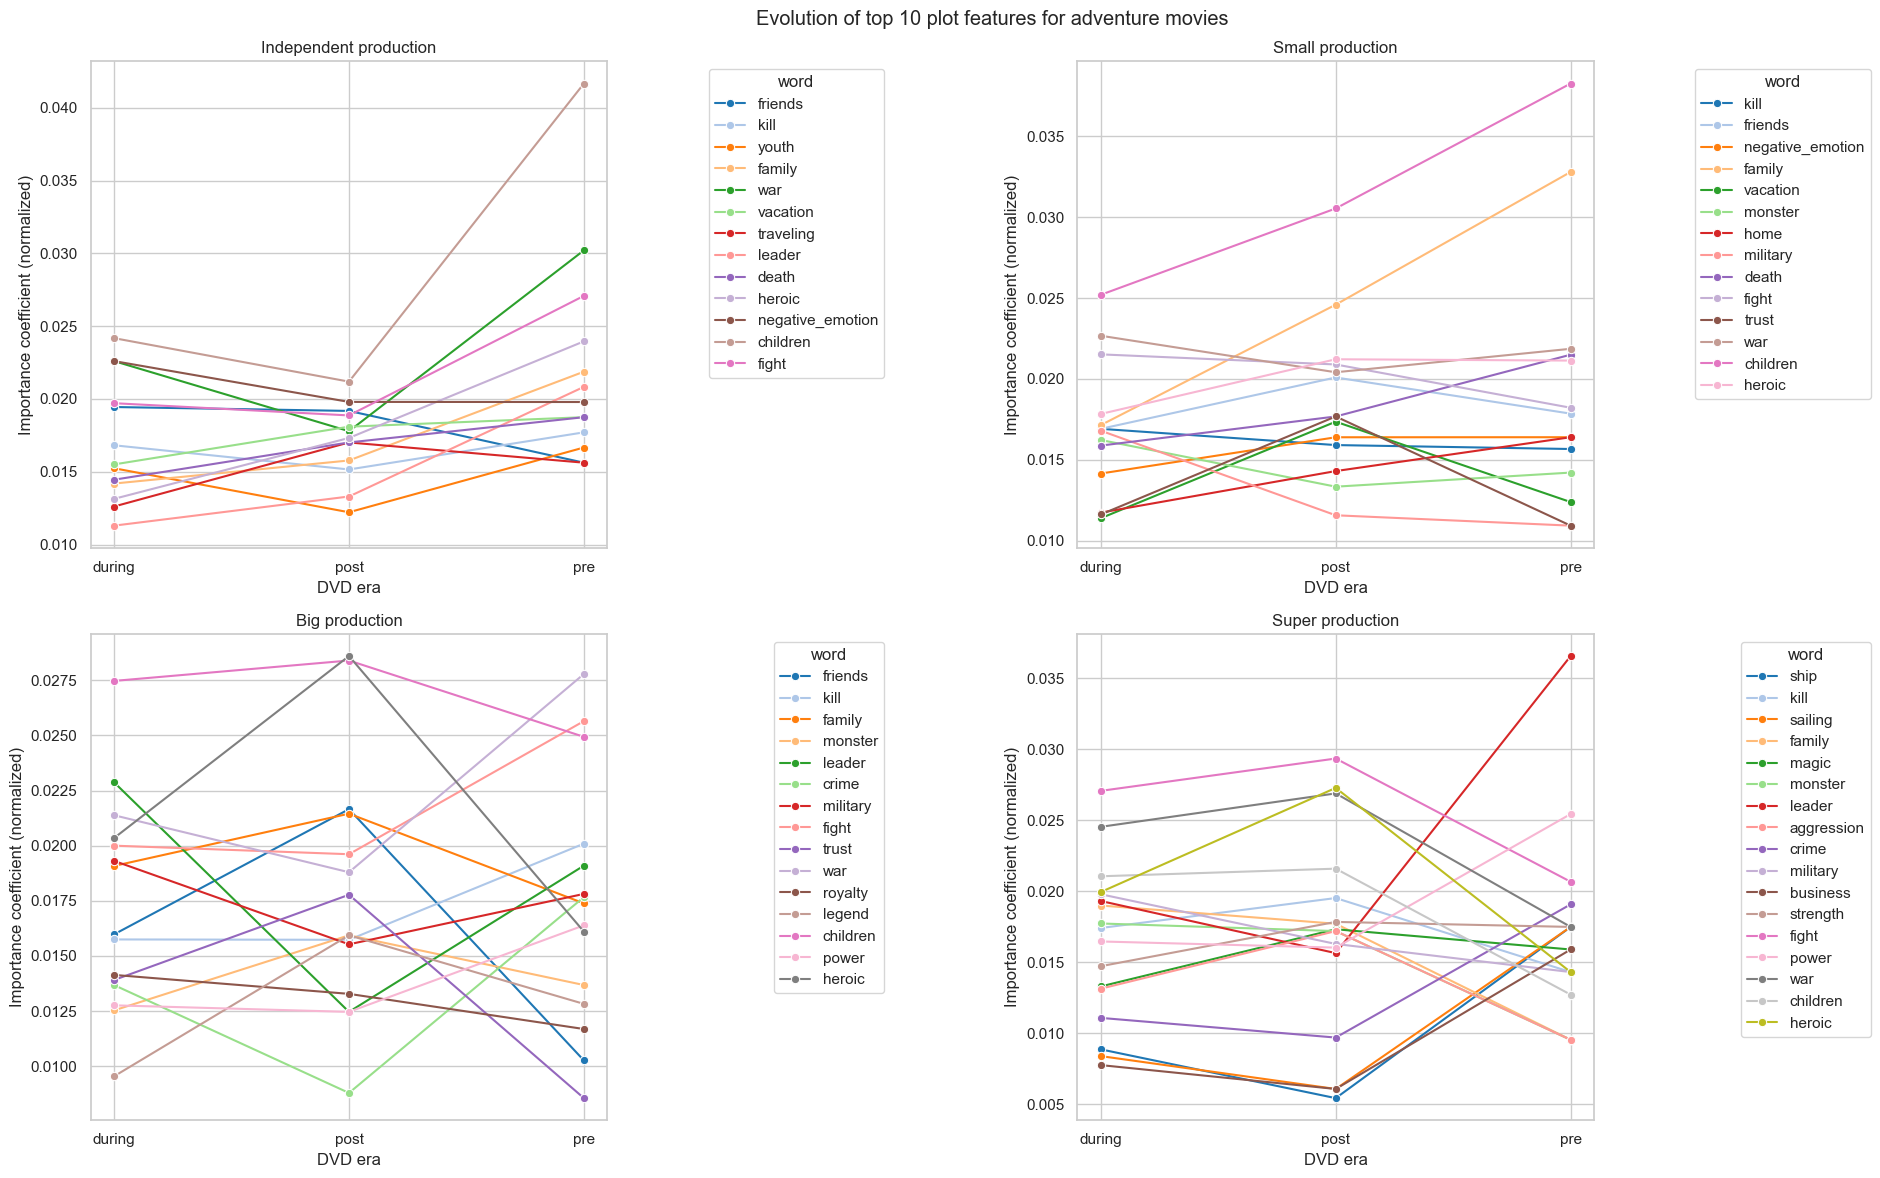

In [42]:
empathModel.plot_all_features(results, 'adventure')

## Production countries

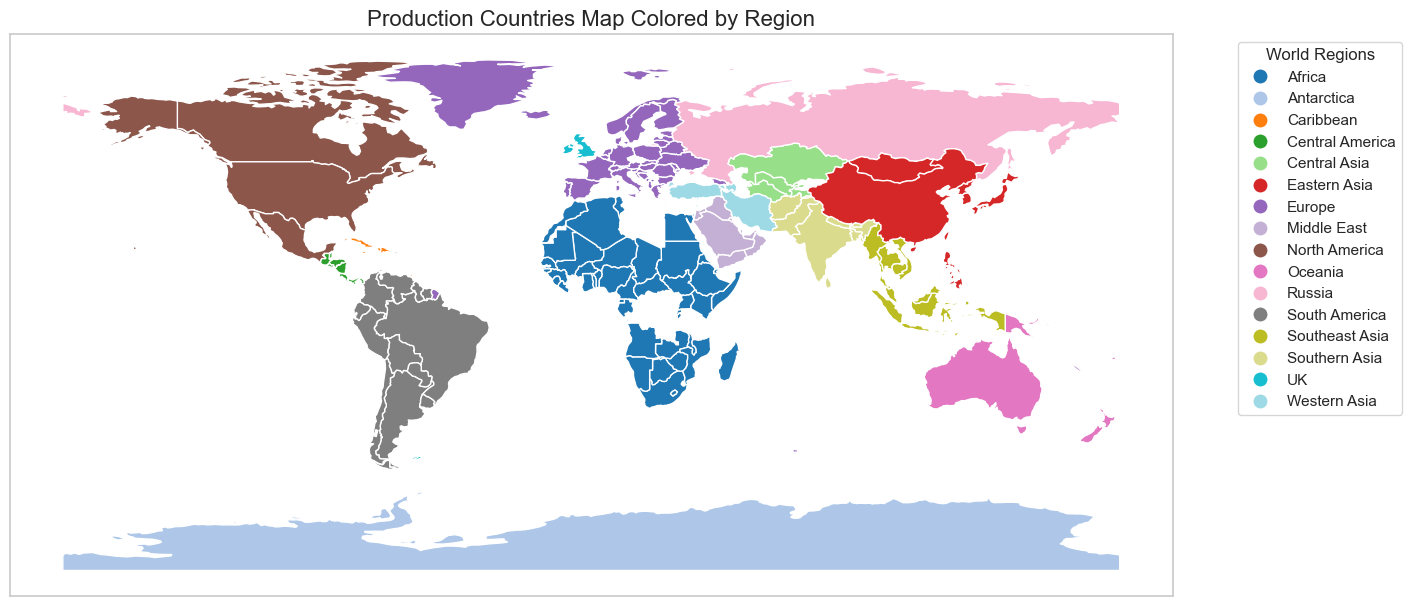

In [9]:
with open('./data/countries_to_region.json', 'r') as file:
    countries_regions = json.loads(file.read())
    
plot_world_map(countries_regions)

In [132]:
df_countries = df.copy().explode('production_countries')
df_countries = df_countries.explode('genres')
df_countries['region'] = df_countries.production_countries.apply(lambda x: countries_regions[x] if x in countries_regions and pd.notna(x) else None)
df_countries.dropna(subset=['region'], inplace=True)

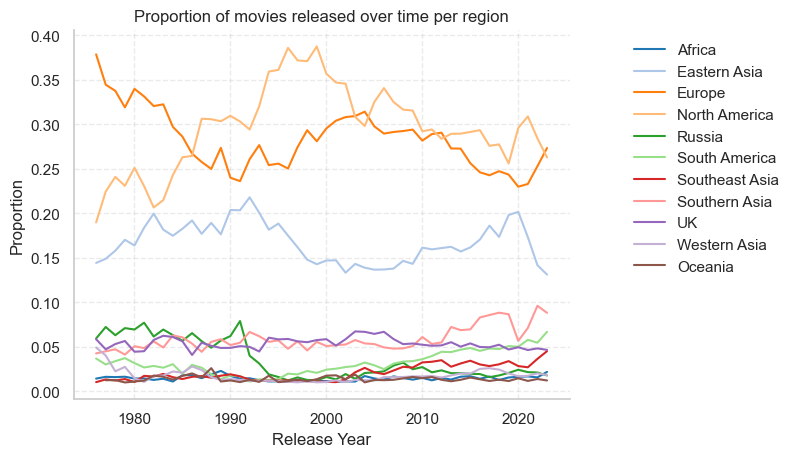

In [156]:
region_props = get_proportions(df_countries, ['release_year'], 'region')

# for website: 
# region_props = pd.read_csv('./data/website_data/region_props.csv')

sns.lineplot(data=region_props[region_props.prop > 0.01], x='release_year', y='prop', hue='region', palette='tab20')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1), frameon=False)
style_plot('Proportion of movies released over time per region', 'Release Year', 'Proportion')
plt.show()

In [157]:
selected_regions = list(region_props[region_props.prop > 0.05].region.unique())

In [185]:
df_countries_filtered = df_countries[(df_countries.region.isin(selected_regions))
                                     & (df_countries.budget > 0)]

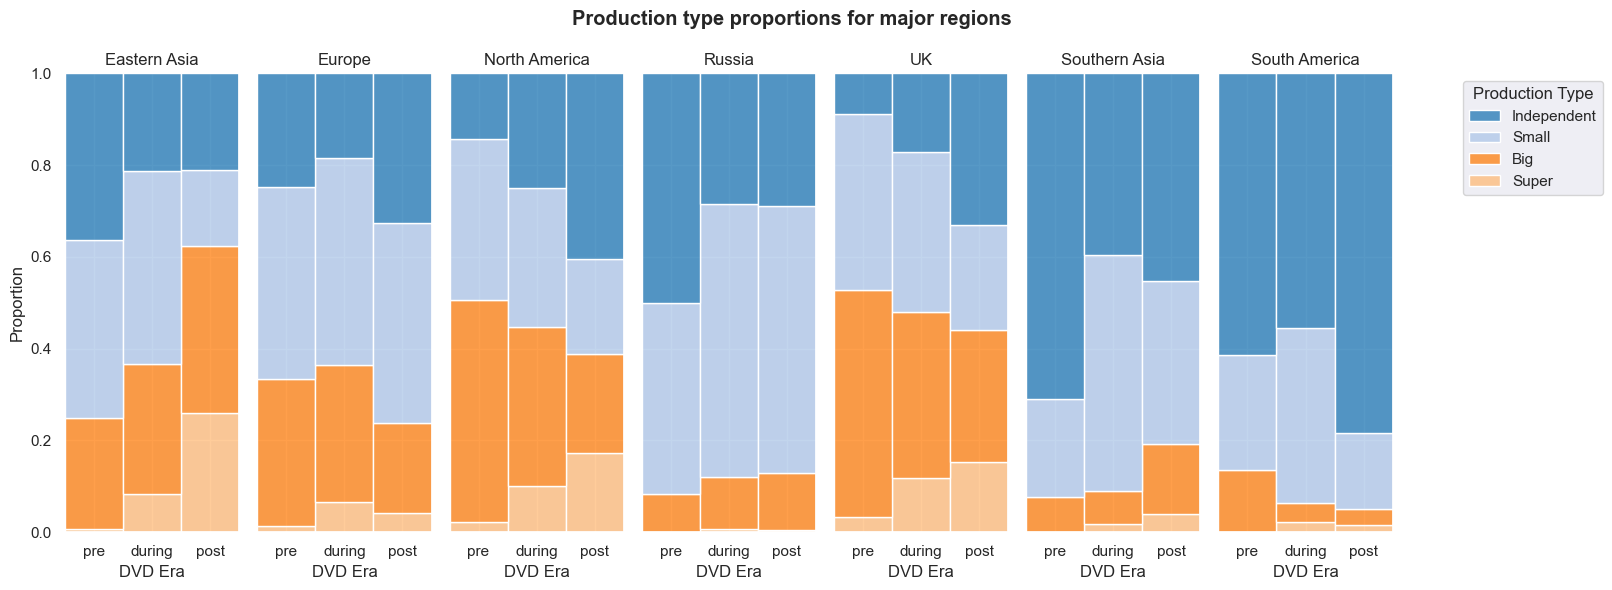

In [192]:
f, axs = plt.subplots(1, len(selected_regions), figsize=(16, 6), sharey=True)

for i, region in enumerate(selected_regions):
    ax = axs[i]
    legend = False if (i < len(selected_regions) - 1) else 'full'
    sns.histplot(data=df_countries_filtered[(df_countries_filtered['region'] == region)], x='dvd_era', hue='prod_type', 
                 multiple='fill', legend=legend, ax=ax, hue_order=['Independent', 'Small', 'Big', 'Super'], palette='tab20')
    ax.set_title(region)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('DVD Era')
sns.move_legend(axs[len(selected_regions)-1], loc='upper right', bbox_to_anchor=(2.25,1),title='Production Type')
f.suptitle('Production type proportions for major regions', fontweight='bold')
plt.tight_layout()
plt.show()

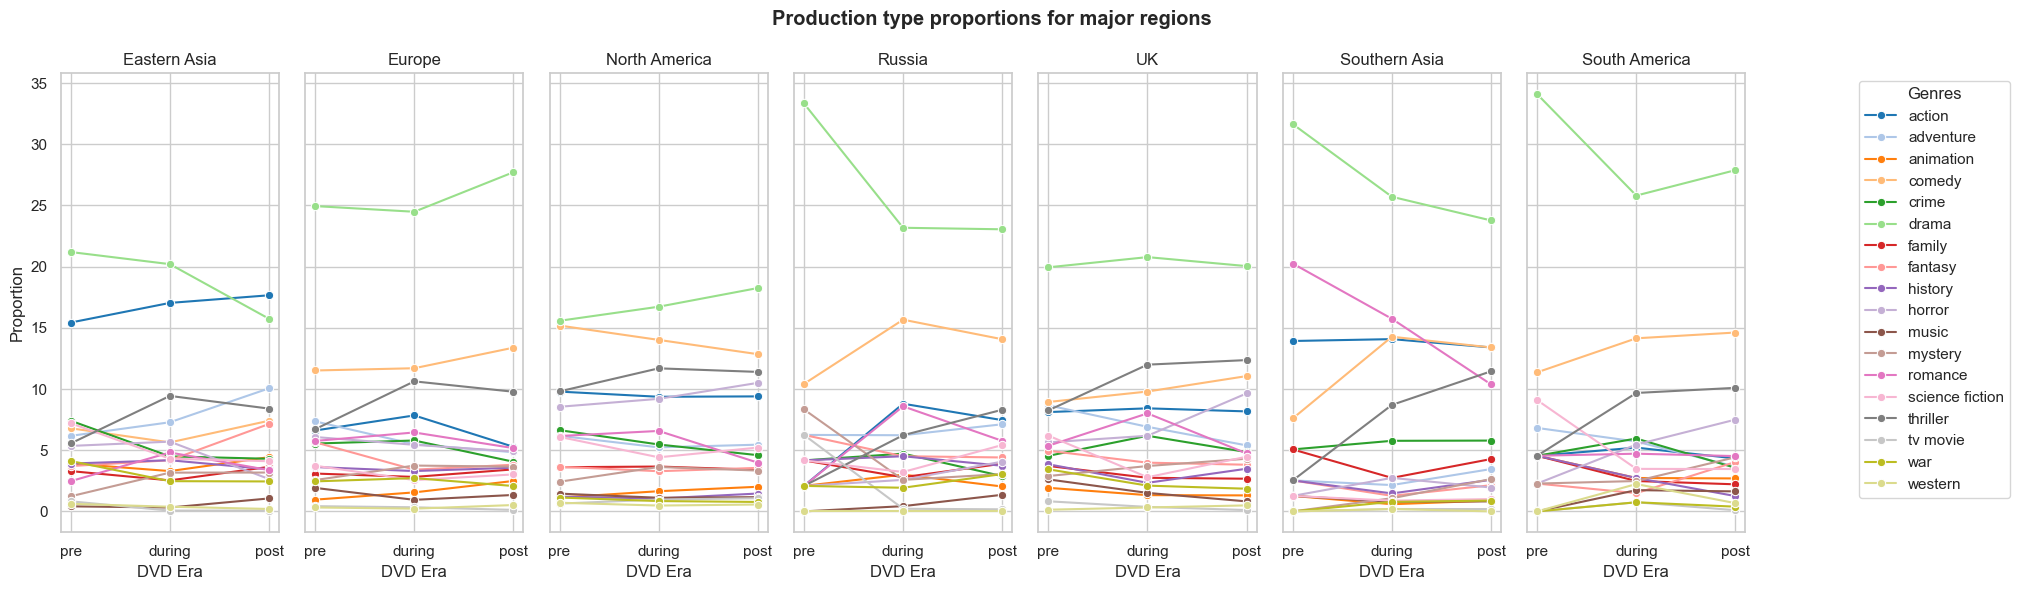

In [187]:
countries_genres_props = get_proportions(df_countries_filtered, ['dvd_era', 'region'], 'genres')

sns.set(style="whitegrid")
f, axs = plt.subplots(1, len(selected_regions), figsize=(20, 6), sharey=True)
# Loop through each production type
for i, region in enumerate(selected_regions):
    # Filter data for the current production type
    subset = countries_genres_props[countries_genres_props['region'] == region]
    # Plot the evolution of proportions for genres across DVD eras
    ax = axs[i]
    legend = False if (i < len(selected_regions) - 1) else 'full'
    sns.lineplot(data=subset, x='dvd_era', y='prop', hue='genres', marker='o', ax=ax, legend=legend, palette='tab20')
    ax.set_ylabel('Proportion')
    ax.set_xlabel('DVD Era')
    ax.set_title(region)
        
sns.move_legend(axs[len(selected_regions)-1], loc='upper right', bbox_to_anchor=(2.25,1),title='Genres')
f.suptitle('Production type proportions for major regions', fontweight='bold')
plt.tight_layout()
plt.show()

# CMU

In [43]:
from src.data.process_data import create_cmu_tmdb_dataset

df = create_cmu_tmdb_dataset(cmu_movies_path='data/processed/movies.csv', plots_path='data/processed/plot_summaries.csv', 
                             tmdb_path='data/processed/TMDB_clean.csv', how_merge='inner')
mean_budgets = df[df.budget > 0].groupby('release_year').agg(mean_budget=('budget', 'mean'))
df['prod_type'] = df.apply(categorize_production, axis=1, args=(mean_budgets,))
df = df[df['dvd_era'].isin(['pre', 'during'])]
df['dvd_era'] = pd.Categorical(df['dvd_era'], categories=['pre', 'during'], ordered=True)
df['prod_type'] = pd.Categorical(df['prod_type'], categories=['Independent', 'Small', 'Big', 'Super'], ordered=True)

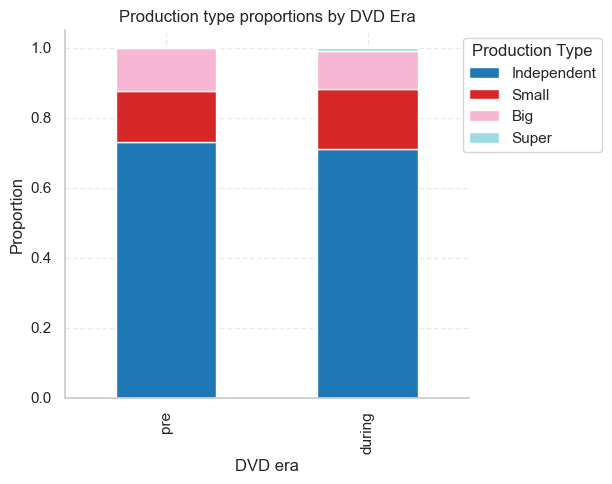

In [44]:
prod_type_proportions = get_proportions(df, base_vars=['dvd_era'], target_var='prod_type')
prod_type_proportions.to_csv('data/website_data/CMU/prod_type_proportions.csv', index=False)
prod_type_proportions.pivot_table(index='dvd_era', columns='prod_type', values='prop', fill_value=0,
                                  observed=False).plot(kind='bar', stacked=True, colormap='tab20')
plt.legend(title="Production Type", bbox_to_anchor=(1.35, 1), loc='upper right')
plt.tight_layout()
style_plot("Production type proportions by DVD Era", "DVD era", "Proportion")

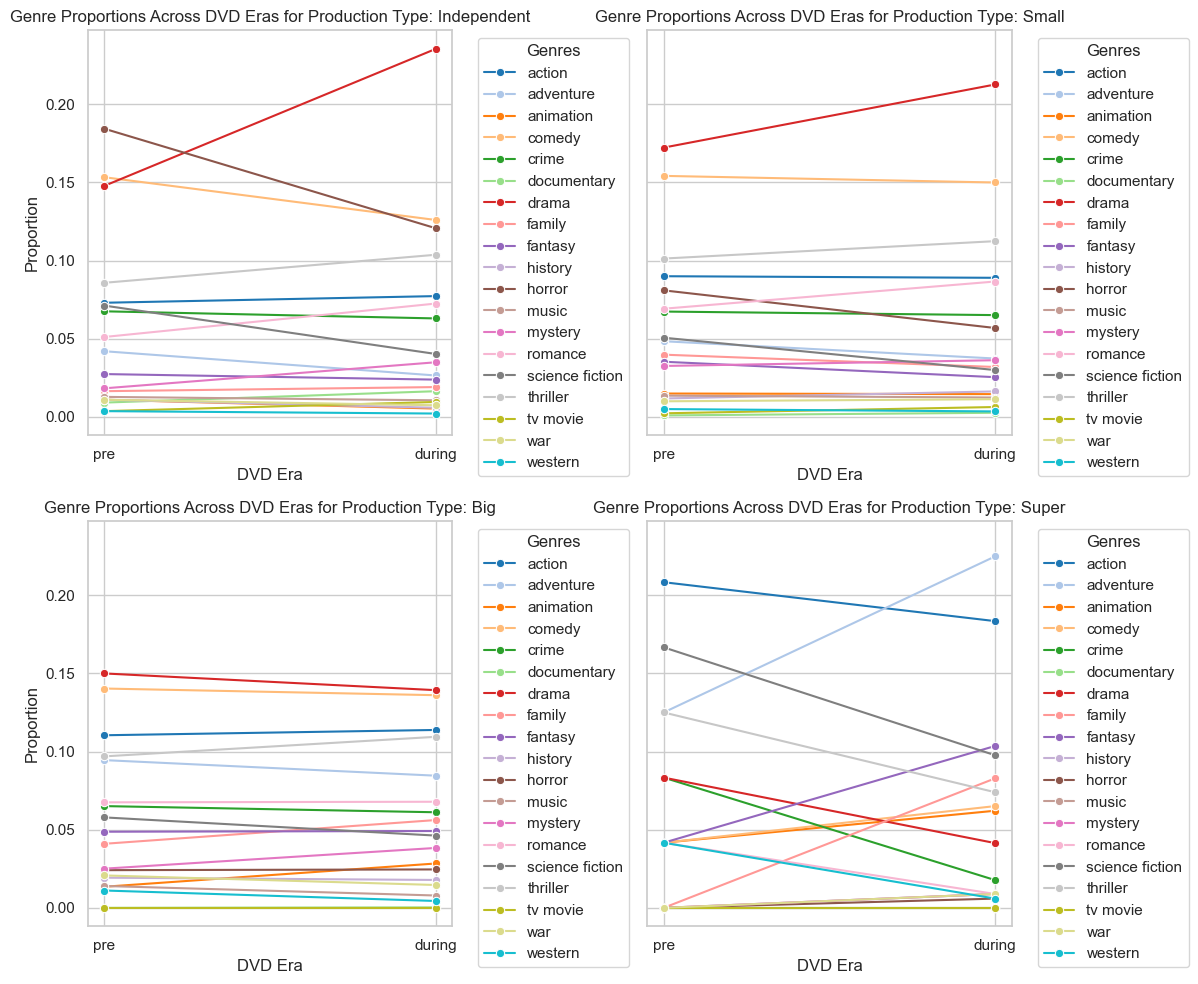

In [45]:
df_genres = df[df.genres.apply(lambda x: len(x) > 0)].copy()
df_genres = df_genres.explode('genres')
df_genres.head()
df_genres = df_genres[df_genres.budget > 0]
genre_proportions = get_proportions(df_genres, base_vars=['prod_type', 'dvd_era'], target_var='genres')

sns.set(style="whitegrid")
f, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
# Loop through each production type
for i, prod_type in enumerate(genre_proportions['prod_type'].unique()):
    subset = genre_proportions[genre_proportions['prod_type'] == prod_type]

    ax = axs.flatten()[i]
    sns.lineplot(data=subset, x='dvd_era', y='prop', hue='genres', marker='o', ax=ax, palette='tab20')
    ax.set_title(f"Genre Proportions Across DVD Eras for Production Type: {prod_type}")
    ax.set_xlabel('DVD Era')
    ax.set_ylabel('Proportion')

    ax.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

plt.show()

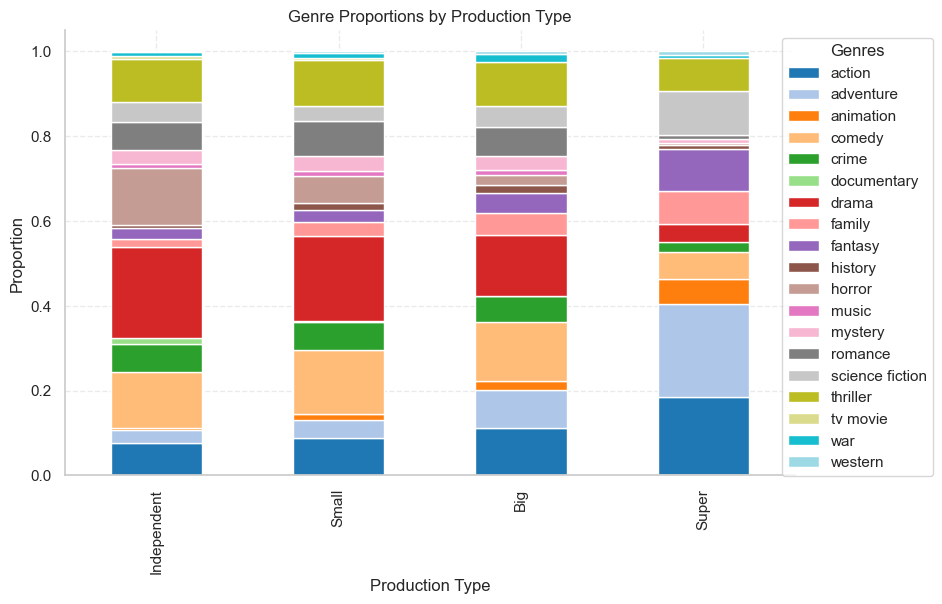

In [46]:
grouped_genres = genre_proportions.groupby(['prod_type', 'genres'], observed=False).sum('count').reset_index()
grouped_genres['proportion'] = grouped_genres['count'] / grouped_genres['total']
# Pivot the DataFrame
pivot_df = grouped_genres.pivot_table(index='prod_type', columns='genres', values='proportion', fill_value=0,
                                      observed=False)

pivot_df.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='tab20')
plt.tight_layout()
plt.legend(title="Genres", bbox_to_anchor=(1.2, 1), loc='upper right')
style_plot("Genre Proportions by Production Type", "Production Type", "Proportion")

In [20]:
df_genres['clean_overview'] = df_genres.overview.apply(clean_text)
empathModel = EmpathModel()
selected_genres = ['drama', 'comedy', 'action', 'adventure']
prod_types = ['Independent', 'Small', 'Big', 'Super']
results = empathModel.get_features_genres_prods(df_genres, selected_genres, prod_types)

Extracting features for Independent drama movies
Extracting features for Small drama movies
Extracting features for Big drama movies
Extracting features for Super drama movies
Extracting features for Independent comedy movies
Extracting features for Small comedy movies
Extracting features for Big comedy movies
Extracting features for Super comedy movies
Extracting features for Independent action movies
Extracting features for Small action movies
Extracting features for Big action movies
Extracting features for Super action movies
Extracting features for Independent adventure movies
Extracting features for Small adventure movies
Extracting features for Big adventure movies
Extracting features for Super adventure movies


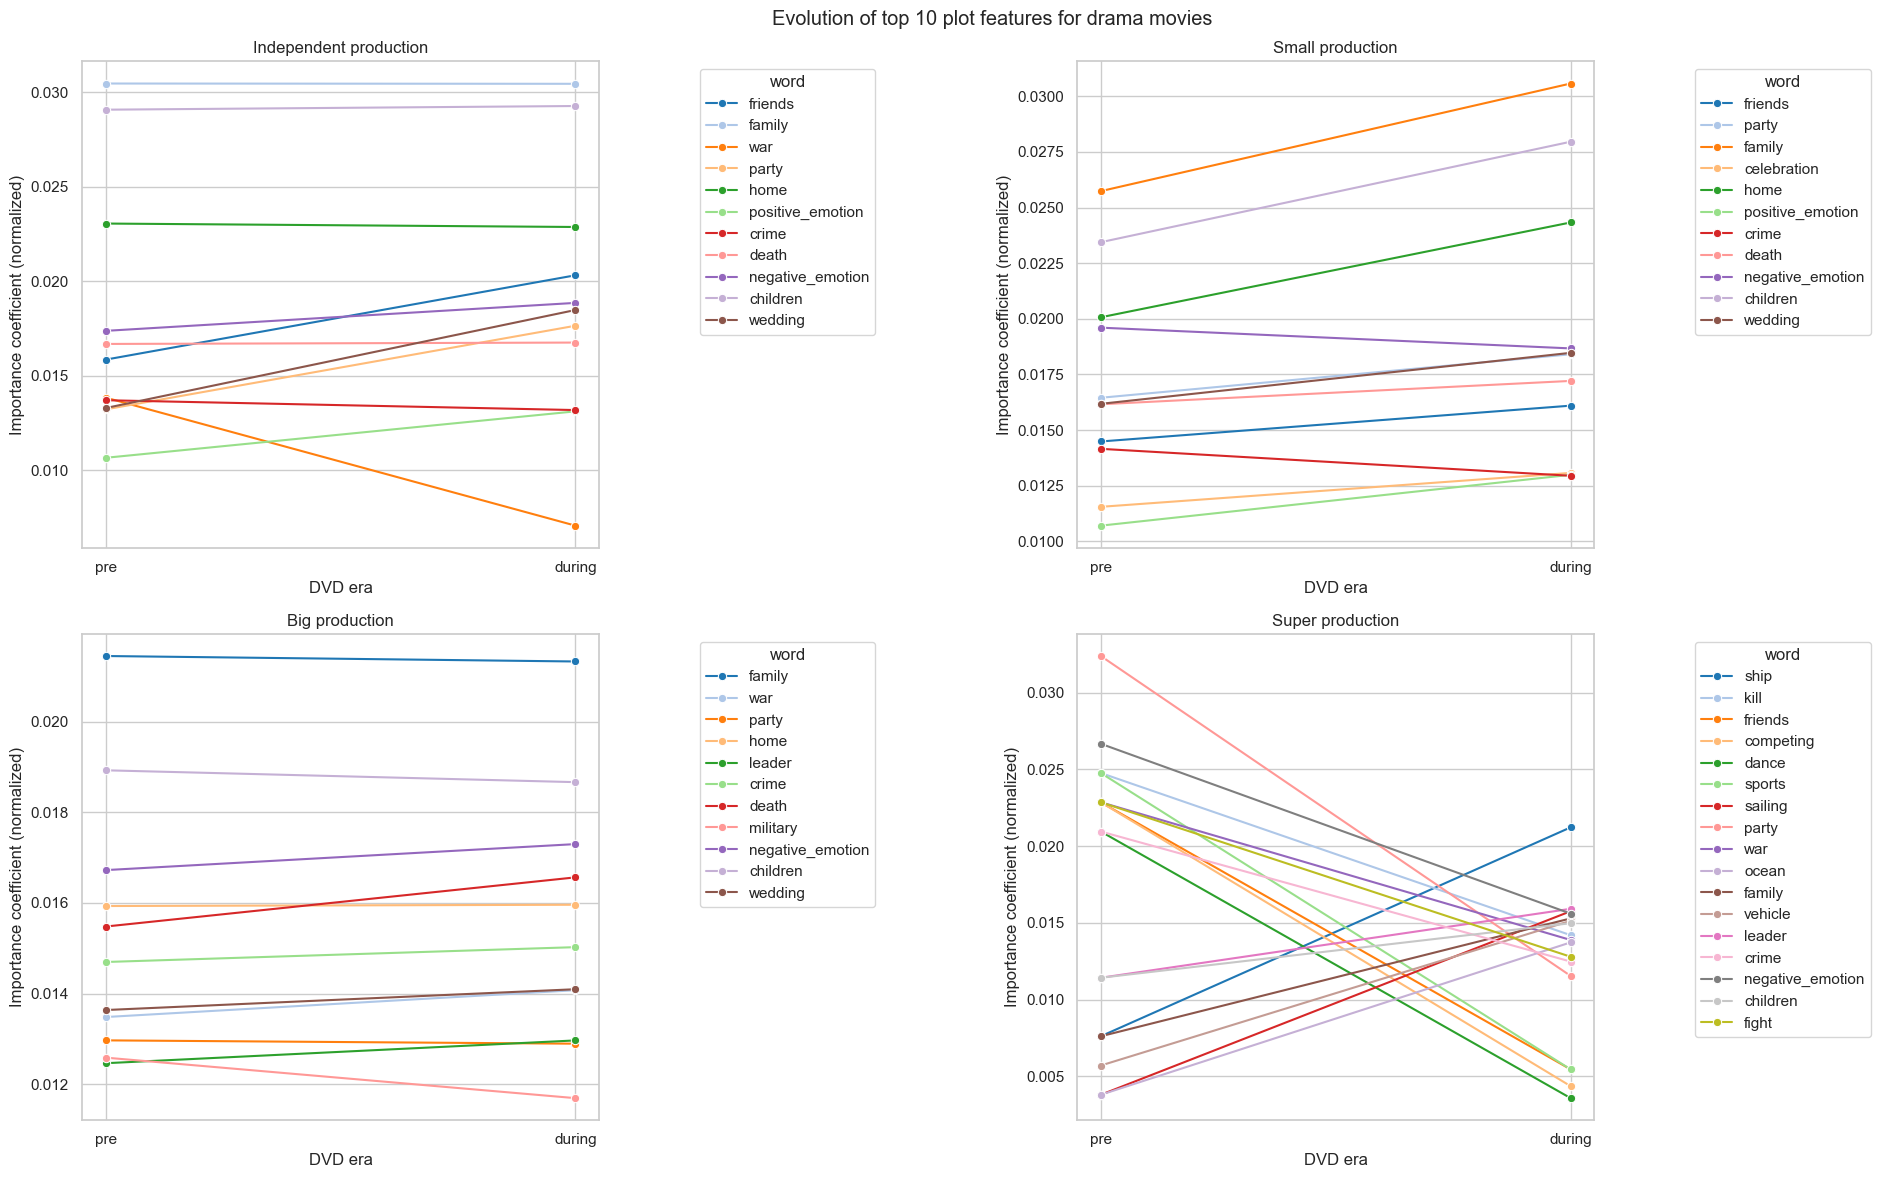

In [22]:
empathModel.plot_all_features(results, 'drama')

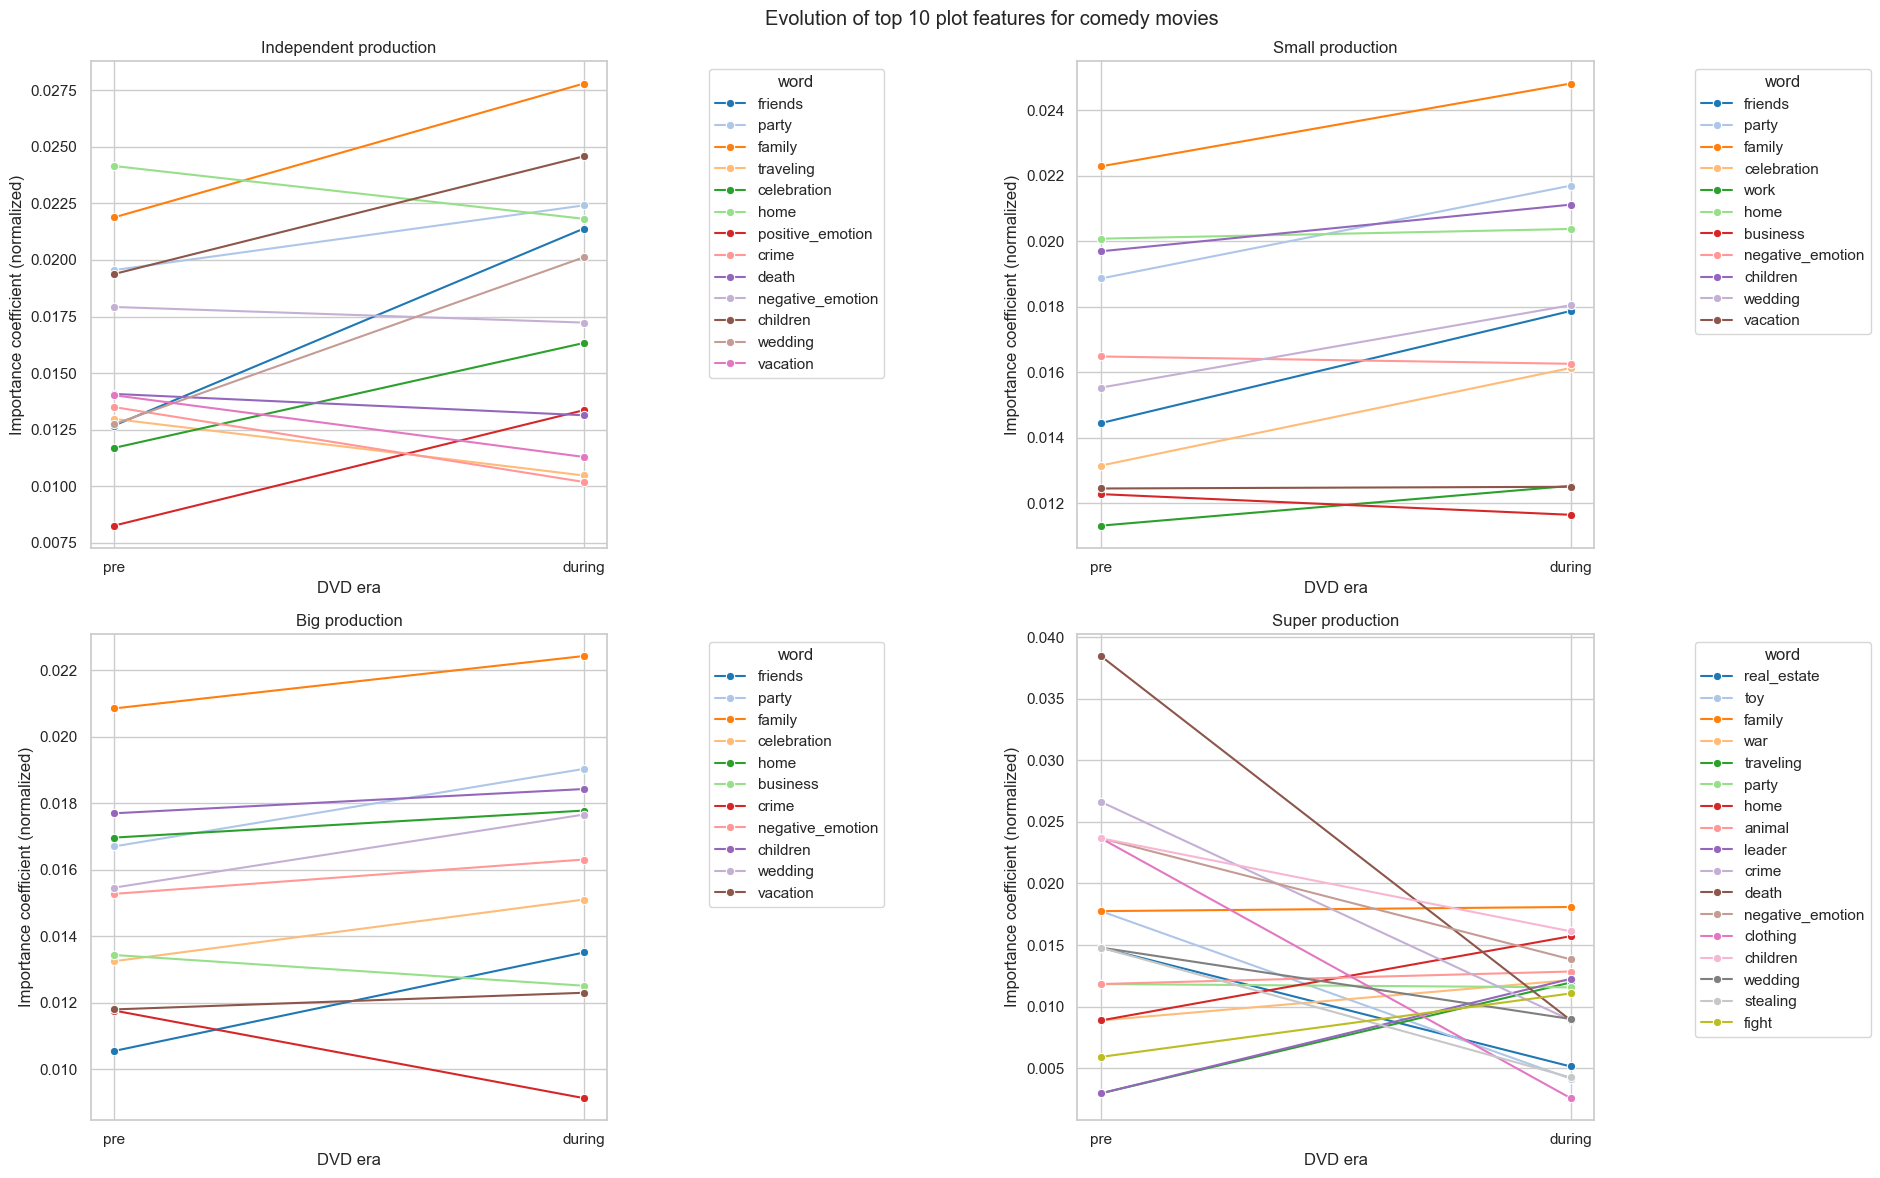

In [23]:
empathModel.plot_all_features(results, 'comedy')

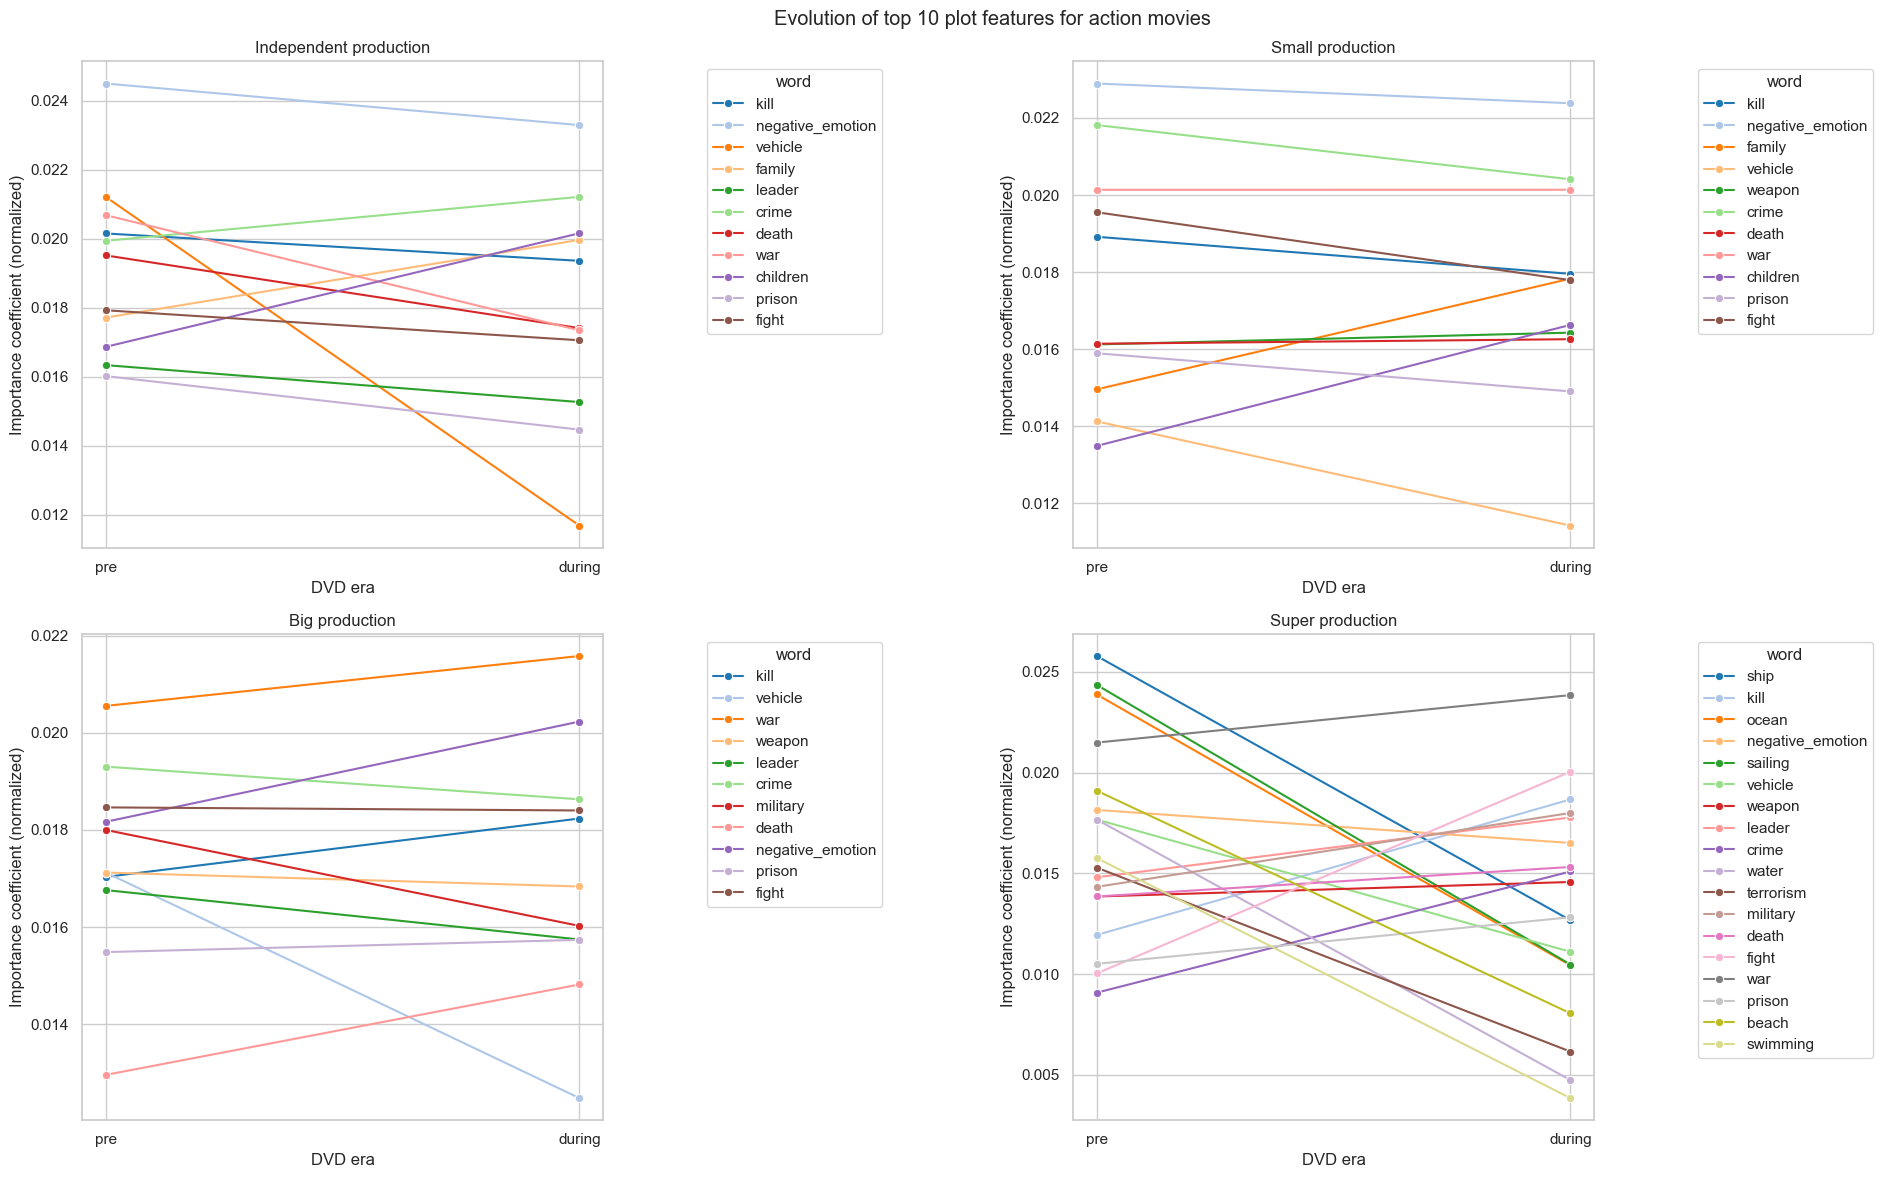

In [25]:
empathModel.plot_all_features(results, 'action')

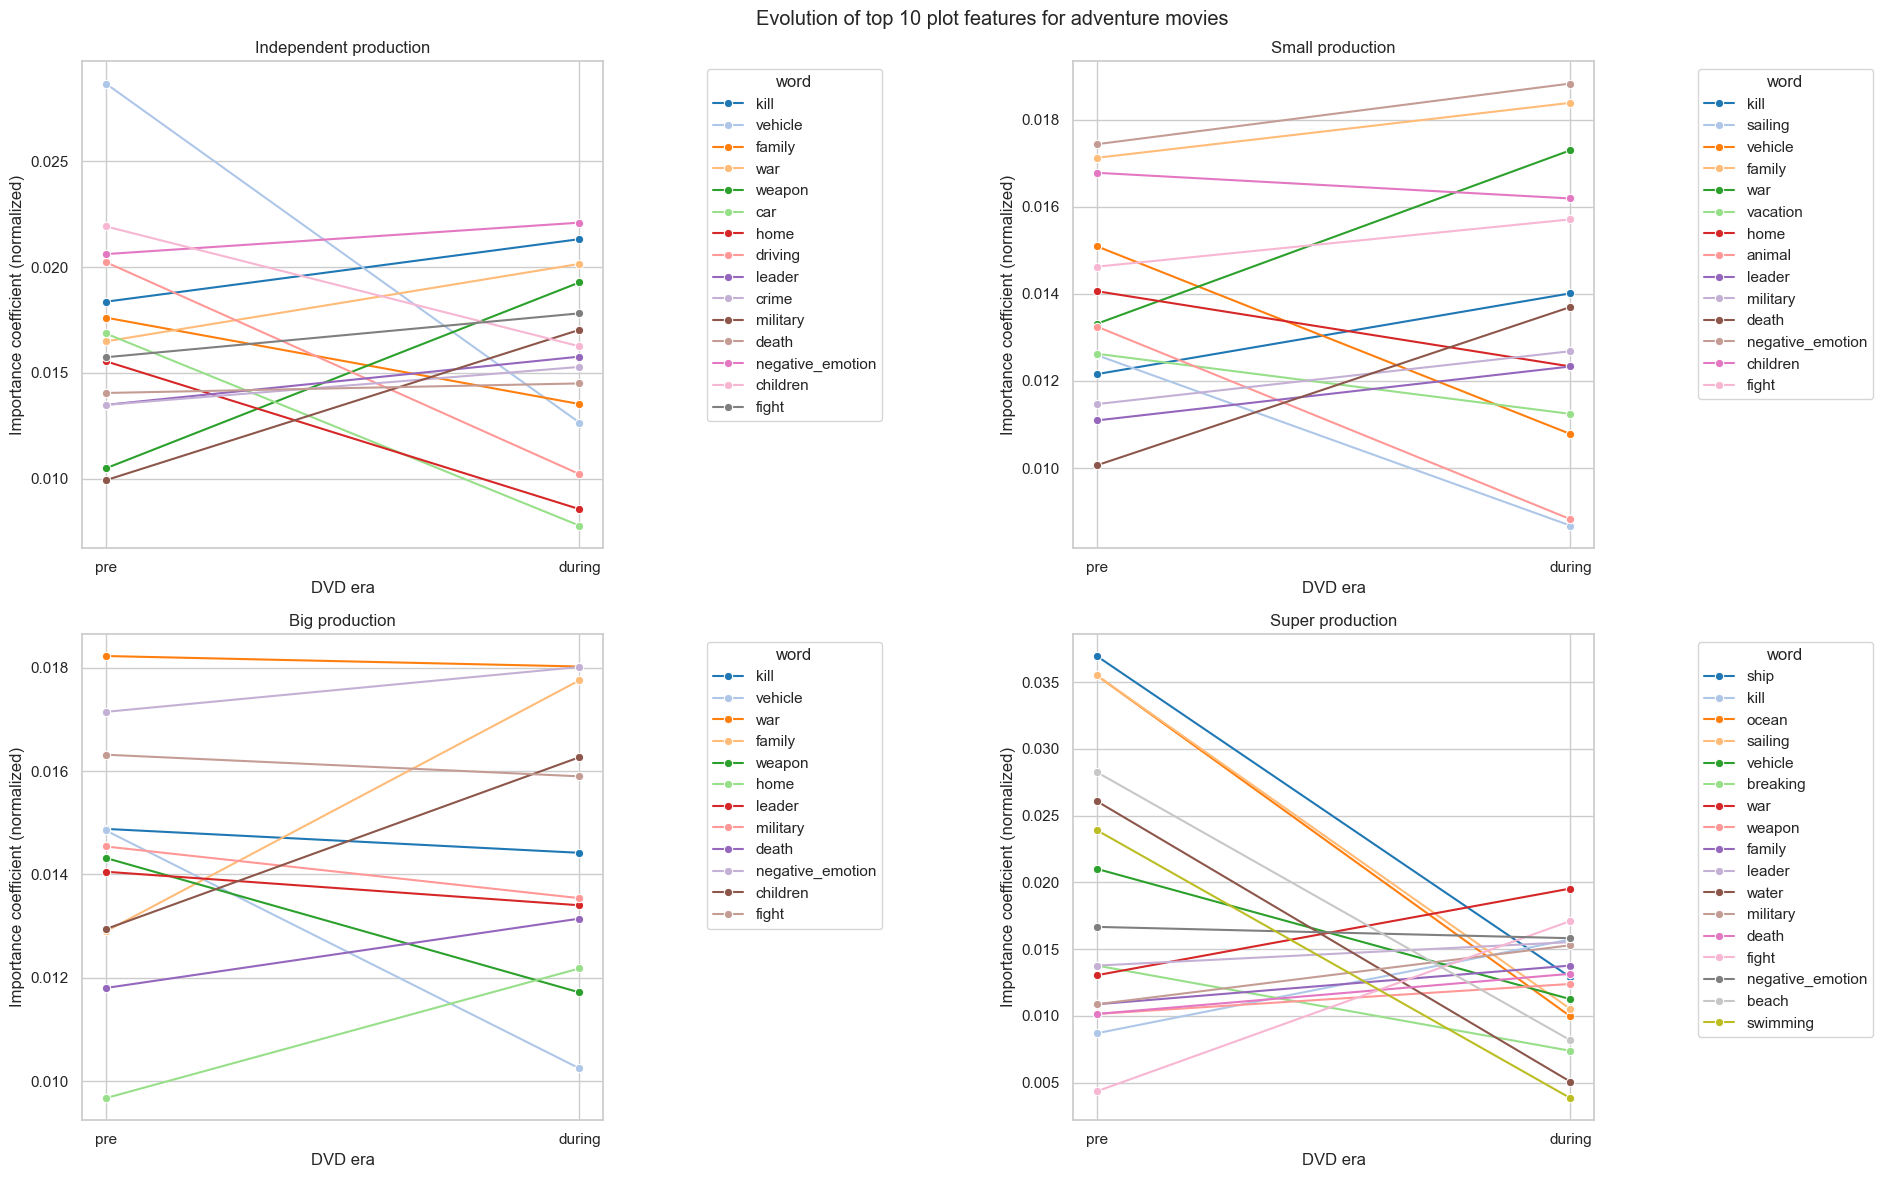

In [24]:
empathModel.plot_all_features(results, 'adventure')


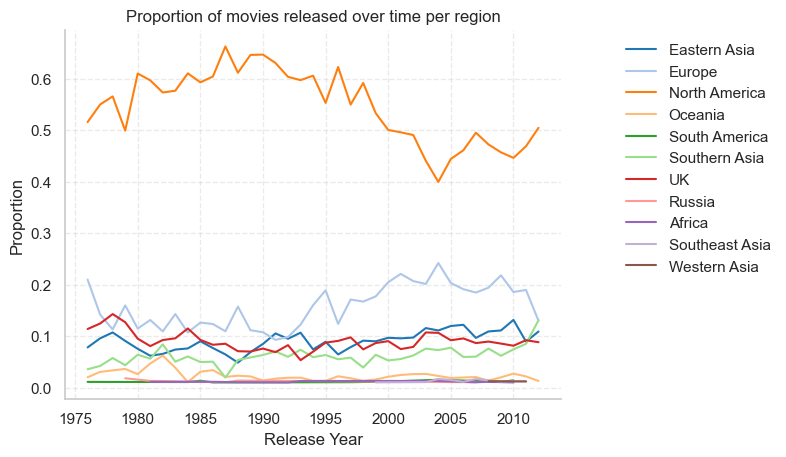

In [47]:
df_countries = df.copy().explode('production_countries')
df_countries = df_countries.explode('genres')
df_countries['region'] = df_countries.production_countries.apply(
    lambda x: countries_regions[x] if x in countries_regions and pd.notna(x) else None)
df_countries.dropna(subset=['region'], inplace=True)

region_props = get_proportions(df_countries, ['release_year'], 'region')

sns.lineplot(data=region_props[region_props.prop > 0.01], x='release_year', y='prop', hue='region', palette='tab20')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1), frameon=False)
style_plot('Proportion of movies released over time per region', 'Release Year', 'Proportion')
plt.show()

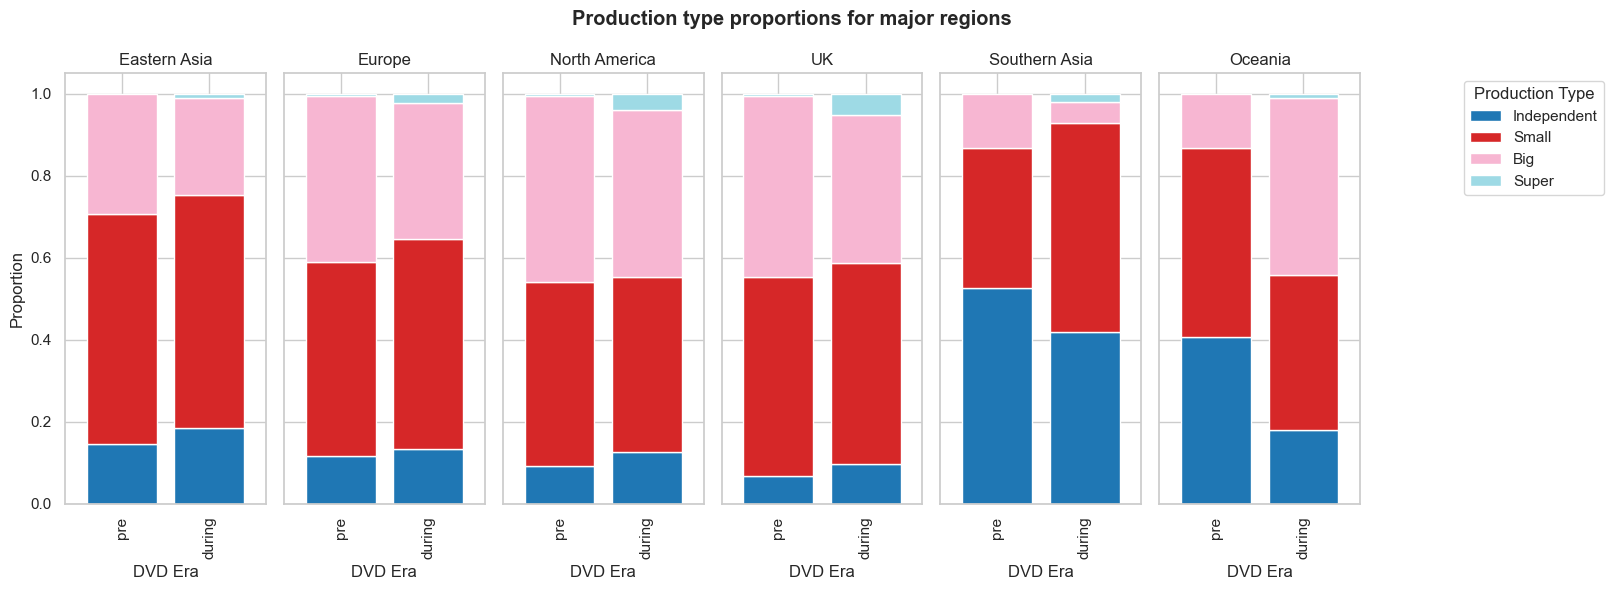

In [48]:
region_prod_props = get_proportions(df_countries_filtered, ['region','dvd_era'], 'prod_type')
f, axs = plt.subplots(1, len(selected_regions), figsize=(16, 6), sharey=True)

for i, region in enumerate(selected_regions):
    ax = axs[i]
    legend = False if (i < len(selected_regions) - 1) else True

    (region_prod_props[region_prod_props.region == region].
     pivot_table(index='dvd_era', columns='prod_type', values='prop', fill_value=0, observed=False)[
         ['Independent', 'Small', 'Big', 'Super']].
     plot(kind='bar', stacked=True, colormap='tab20', ax=ax, legend=legend, width=0.8))
    ax.set_title(region)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('DVD Era')
sns.move_legend(axs[len(selected_regions) - 1], loc='upper right', bbox_to_anchor=(2.25, 1), title='Production Type')
f.suptitle('Production type proportions for major regions', fontweight='bold')
plt.tight_layout()
plt.show()

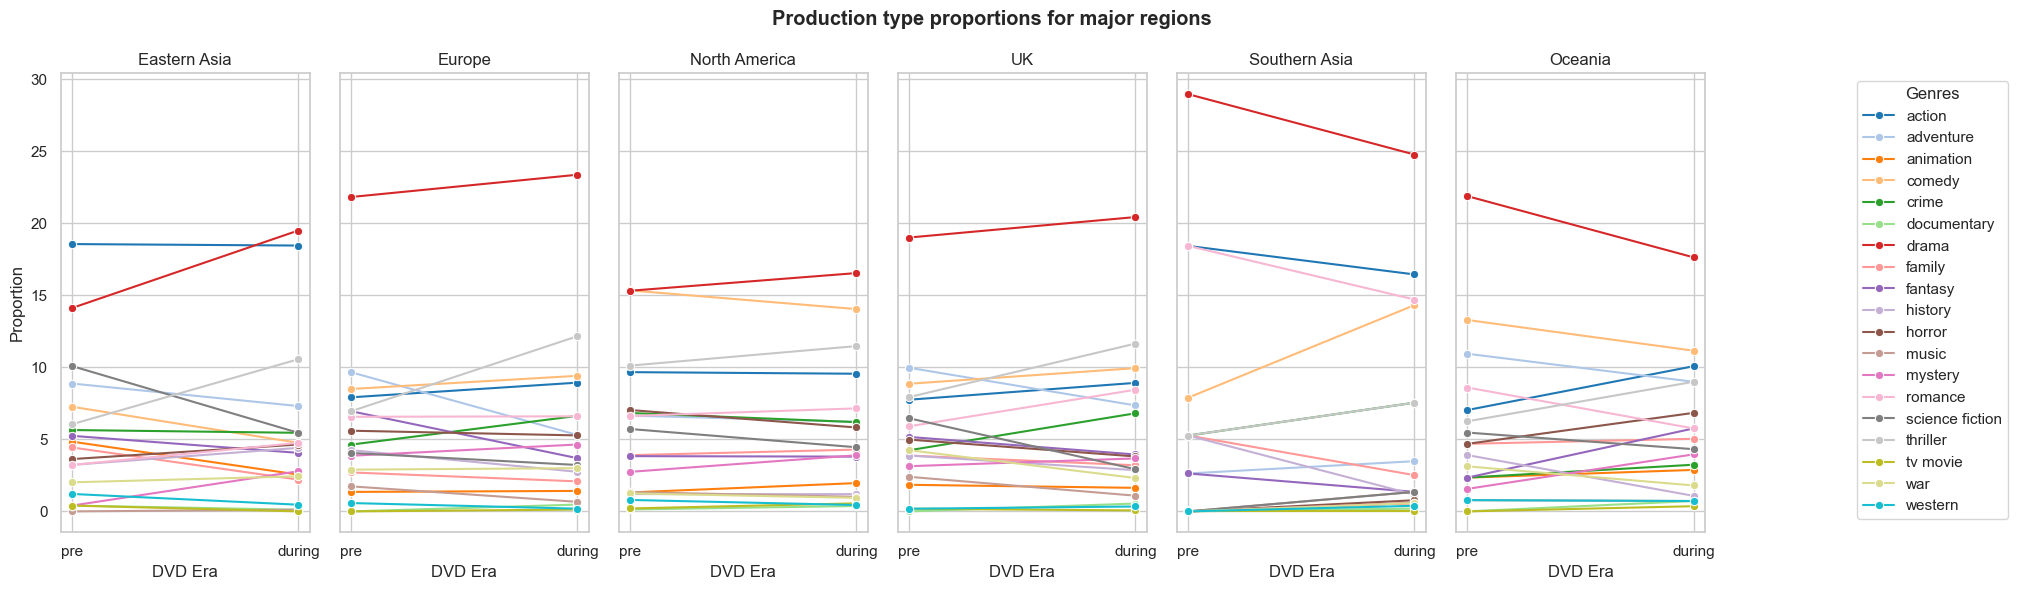

In [49]:
countries_genres_props = get_proportions(df_countries_filtered, ['dvd_era', 'region'], 'genres')
countries_genres_props.to_csv('data/website_data/CMU/region_genres_props.csv')
sns.set(style="whitegrid")
f, axs = plt.subplots(1, len(selected_regions), figsize=(20, 6), sharey=True)
# Loop through each production type
for i, region in enumerate(selected_regions):
    # Filter data for the current production type
    subset = countries_genres_props[countries_genres_props['region'] == region]
    subset.loc[:,'prop'] = subset['prop'].apply(lambda x : x*100)
    # Plot the evolution of proportions for genres across DVD eras
    ax = axs[i]
    legend = False if (i < len(selected_regions) - 1) else 'full'
    sns.lineplot(data=subset, x='dvd_era', y='prop', hue='genres', marker='o', ax=ax, legend=legend, palette='tab20')
    ax.set_ylabel('Proportion')
    ax.set_xlabel('DVD Era')
    ax.set_title(region)
        
sns.move_legend(axs[len(selected_regions)-1], loc='upper right', bbox_to_anchor=(2.25,1),title='Genres')
f.suptitle('Production type proportions for major regions', fontweight='bold')
plt.tight_layout()
plt.show()